<a href="https://colab.research.google.com/github/SaifullahKatpar/PySpark/blob/master/NY_Taxi_x07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Spark

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.3.4/spark-2.3.4-bin-hadoop2.7.tgz
!tar xf spark-2.3.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
# Install dependencies
!pip install pyshp

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.4-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark import SparkConf
SparkConf().set("spark.executor.memory", "13g")

In [0]:
# Import the PySpark module
from pyspark.sql import SparkSession

# Create SparkSession object
spark = SparkSession.builder.master('local[*]').appName('test').getOrCreate()


# What version of Spark?
print(spark.version)

2.3.4


# Libaries

In [0]:
from pyspark import SparkFiles
import time
import pandas as pd
from pyspark.sql.types import IntegerType, TimestampType, DoubleType, StringType, DoubleType, StructType, StructField
from pyspark.sql.functions import col
import shapefile
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as func

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


 # 2. Loading data as parquet files

##Part-I

## 1. Read without imposing a schema.

**Answer:** Read with inferSchema as None. If None is set, it uses the default value, false.


In [0]:
url_2015 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-05.csv"
spark.sparkContext.addFile(url_2015)
df_2015 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2015-05.csv"), header=True)


In [0]:
url_2018 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-05.csv"
spark.sparkContext.addFile(url_2018)
df_2018 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-05.csv"), header=True)


##2. Inspect the inferred schema. Do you agree with Spark’s typing decision?

**Answer:** No. I disagree with the inferred schema as it sets the datatype of every column to string regardless of the value present in column

In [0]:
df_2015.printSchema()

In [0]:
df_2018.printSchema()

##3. Eventually correct the schema and read again the data.

**Answer**: There are two ways to correct the schema. 


**1. While reading data, set inferSchema = True. It requires one extra pass over the data to get the input schema automatically from data.**


In [0]:
# df_2015_inferred = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2015-01.csv"), header=True, inferSchema = True)

In [0]:
# df_2018_inferred = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-01.csv"), header=True, inferSchema = True)

In [0]:
# df_2015_inferred.printSchema()
# df_2018_inferred.printSchema()

**2. Force schema**

In [0]:
schema_2015 = StructType([
    StructField("VendorID", IntegerType()),
    StructField("tpep_pickup_datetime", TimestampType()),
    StructField("tpep_dropoff_datetime", TimestampType()),
    StructField("passenger_count", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("RateCodeID", IntegerType()),
    StructField("store_and_fwd_flag", StringType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", IntegerType()),
    StructField("fare_amount", DoubleType()),
    StructField("extra", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("improvement_surcharge", DoubleType()),
    StructField("total_amount", DoubleType())
])

schema_2018 = StructType([
    StructField("VendorID", IntegerType()),
    StructField("tpep_pickup_datetime", TimestampType()),
    StructField("tpep_dropoff_datetime", TimestampType()),
    StructField("passenger_count", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("RateCodeID", IntegerType()),
    StructField("store_and_fwd_flag", StringType()),
    StructField("PULocationID", IntegerType()),
    StructField("DOLocationID", IntegerType()),
    StructField("payment_type", IntegerType()),
    StructField("fare_amount", DoubleType()),
    StructField("extra", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("improvement_surcharge", DoubleType()),
    StructField("total_amount", DoubleType())
])

In [0]:
url_2015 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-05.csv"
spark.sparkContext.addFile(url_2015)
df_2015_schema = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2015-05.csv"), header=True, nullValue='NA', schema=schema_2015)

In [0]:
url_2018 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-05.csv"
spark.sparkContext.addFile(url_2018)
df_2018_schema = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-05.csv"), header=True, nullValue='NA', schema=schema_2018)

## 4. Save the data into parquet files given number of partitions and partition column

In [0]:
df_2015_schema.repartition(1).write.partitionBy('VendorID').mode(
"overwrite").parquet("data/df_2015.parquet")

In [0]:
df_2018_schema.repartition(1).write.partitionBy('VendorID').mode(
"overwrite").parquet("data/df_2018.parquet")

##Part-II
**1. What is the StorageLevel of the dataframe after reading the csv files?**

**Answer:** df.storageLevel(useDisk, useMemory, useOffHeap, deserialized, replication)

In [0]:
df_2015.storageLevel

StorageLevel(False, False, False, False, 1)

In [0]:
df_2018.storageLevel

StorageLevel(False, False, False, False, 1)

**2. What is the number of partitions of the dataframe?**

**Answer:**

In [0]:
df_2015.rdd.getNumPartitions()

16

In [0]:
df_2018.rdd.getNumPartitions()

6

**3.Is it possible to tune this number at loading time?**

**Answer:** Yes, we can tune the number of partitions at loading time with coalesce(n).

In [0]:
# df_2015_tuned = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2015-01.csv"), header=True, nullValue='NA', schema=schema_2015).coalesce(10)


In [0]:
# df_2018_tuned = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-01.csv"), header=True, nullValue='NA', schema=schema_2018).coalesce(3)


In [0]:
# df_2015_tuned.rdd.getNumPartitions()

10

In [0]:
# df_2018_tuned.rdd.getNumPartitions()

3

**4. Why would we want to modify the number of partitions when creating the parquet files?**

**Answer:** Becaue we want to utilize the distributive power of Spark and process data efficiently.

#3. Investigate (at least) one month of data in 2015
The following longitudes and lattitudes encompass Newark and JFK airports, Northern Manhattanand Verazzano bridge

**Read parquet files**

In [0]:
parque_2015_df = spark.read.option("mergeSchema", "true").parquet("data/df_2015.parquet")

In [0]:
parque_2015_df.show(2)

In [0]:
long_min=-74.10
long_max=-73.70
lat_min=40.58
lat_max=40.90

Using these boundaries,filter the 2015 data(using pickup and dropoff longitude andlatitude) and count the number of trips for each value of passenger_count and make a plot of that.

In [0]:
filtered_df = parque_2015_df.filter( 
    (func.round(col('pickup_longitude'),2)>= long_min) & 
    (func.round(col('pickup_longitude'),2)<= long_max ) &
    (func.round(col('pickup_latitude'),2)>= lat_min ) & 
    (func.round(col('pickup_latitude'),2)<=  lat_max) &
    (func.round(col('dropoff_longitude'),2)>= long_min) & 
    (func.round(col('dropoff_longitude'),2)<= long_max ) &
    (func.round(col('dropoff_latitude'),2)>= lat_min ) & 
    (func.round(col('dropoff_latitude'),2)<=  lat_max) 
    )

In [0]:
filtered_df.count()

12896295

In [0]:
passenger_grouped = filtered_df.groupBy('passenger_count').count()

In [0]:
passenger_grouped.show()

+---------------+-------+
|passenger_count|  count|
+---------------+-------+
|              1|9038276|
|              6| 465291|
|              3| 553508|
|              5| 701952|
|              9|      5|
|              4| 261812|
|              8|      6|
|              7|     10|
|              2|1872418|
|              0|   3017|
+---------------+-------+



Text(0, 0.5, 'No of trips')

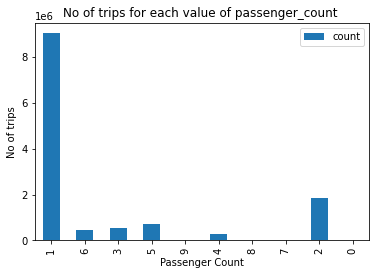

In [0]:
group_df = passenger_grouped.toPandas()
ax = group_df.plot(kind='bar',x='passenger_count',y='count', title = 'No of trips for each value of passenger_count ') 
ax.set_xlabel("Passenger Count")
ax.set_ylabel("No of trips")

**1.What’s special with trips with zero passengers**

These trips do not have anything worth analysing. These trips have mostly 0 trip distance and were charged for that. It means these trips may either be mistakenly booked by the customer or made by the capton to complete his rides.


In [0]:
trips_0 = filtered_df.filter(col('passenger_count')==0)

In [0]:
trips_0.show()

+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|VendorID|
+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+
| 2015-05-22 02:25:56|  2015-05-22 02:27:56|              0|          0.0|-73.95744323730469|40.687721252441406|         5|             

2.What’s special with trips with more than 6 passengers?

There are only 21 trips, which is not significant among the total trips. Trip distance is mostly zero. These trips are outliers and may not add anything to our anlysis. 



In [0]:
trips_6 = filtered_df.filter(col('passenger_count')>6)

In [0]:
trips_6.show()

+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|VendorID|
+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+
| 2015-05-22 15:21:25|  2015-05-22 15:21:56|              9|          0.0|-73.81221008300781| 40.90046691894531|         5|             

3.What is the largest distance travelled during this month? Is it the first taxi on the moon?

In [0]:
max_dist = filtered_df.agg({"trip_distance": "max"}).collect()


In [0]:
print('Max distance travelled OMG =D : ', max_dist[0][0])

Max distance travelled OMG =D :  15700000.0


In [0]:
filtered_df.filter(col('trip_distance')==15700000.0).show()

+--------------------+---------------------+---------------+-------------+------------------+-----------------+----------+------------------+------------------+-----------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|  pickup_latitude|RateCodeID|store_and_fwd_flag| dropoff_longitude| dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|VendorID|
+--------------------+---------------------+---------------+-------------+------------------+-----------------+----------+------------------+------------------+-----------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+
| 2015-05-31 10:07:08|  2015-05-31 10:32:34|              2|       1.57E7|-73.98420715332031|40.75499725341797|         1|                 N|-

4.Plot the distribution of the trip_distance(using an histogram for instance) during year 2105. Focus on trips with non-zero trip distance and trip distance less than 30 miles.

In [0]:
# parque_2015_df = spark.read.option("mergeSchema", "true").parquet("data/df_2015.parquet")
import pyarrow.parquet as pq
df_dist = pq.read_pandas('data/df_2015.parquet', columns=['trip_distance']).to_pandas()
filtered_dist = df_dist[(df_dist['trip_distance']>0)&(df_dist['trip_distance']<30) ]

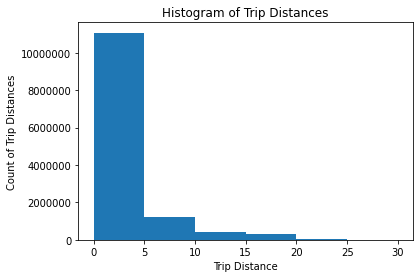

In [0]:
plt.ticklabel_format(style = 'plain')
plt.hist(filtered_dist['trip_distance'], bins=[0,5,10,15,20,25,30])
plt.ylabel('Count of Trip Distances')
plt.xlabel('Trip Distance')
plt.title('Histogram of Trip Distances')
plt.show()


# Let’s look at what Spark does for these computations

1.Use the explain method or have a look at the Spark UIto analyze the job. You should be able to assess 
- Parsed Logical Plan
- Analyzed Logical Plan
- Optimized Logical Plan
- Physical Plan


In [0]:
parque_2015_df.filter(col('passenger_count')>=0).filter(col('passenger_count')<=6).explain(extended = True)

NameError: ignored

2.Do the Analyzed Logical Plan and Optimized Logical Plan differ? Spot the differences if any.How would a RDBMS proceed with such a query?

Yes, they differ. In the optimized logical plan, Spark does optimization itself. It sees that there is no need for two filters. Instead, the same task can be done with only one filter using the and operator, so it does execution in one filter. RDBMS follows optimized logical plan.

3.How does the physical plan differ from the Optimized Logical Plan? What are the keywords you would not expects in a RDBMS? What is their meaning?

There are two types of plans.
1. Logical 
  *   Parsed logical plan
  *   Analysed Logical Plan
  *   Optimized logical Plan

2. physical

Once Optimized Logical Plan is created, Physical Plan is generated. Physical plan is like the bridge between logical plan and spark dstaframe as execution layer does not understand logical plan. 

Physical plan is executed in two phases:
Spark plan
Executed plan

There are some operators shown in query plan.
*   FileScan: Represents reading a data from a file format 
*   Exchange: An operator that represents shuffle, physical data movement on cluster
*   Aggregration: Represents data aggregation

4.Inspect the stages on Spark UI. How many stages are necessary to complete the Spark job? What are the roles of HashAggregate and Exchange hashpartitioning?

**Stages:**

Spark will fire a job when we call an action like collect, count, read etc. It is a sequence of stages or we can say that job is splited into stages. There are two types of transformation in stages:

1.   Narrow (no dependency between partitions to apply action like map, filter)
2.   Wide (dependency between partitions to apply action like join, groupBy Key)

All narro transformations will be executed in one stage. Whenever a wide transformation is written a new stage will be created. For example 
df.filter.groupBy(key), an stage for df.filter is created and each partion will perform filter in that stage than another stage will be created for groupBy(key).

Stages in Apache spark have two categories

1. ShuffleMapStage in Spark
2. ResultStage in Spark

**Role of Exchange hashpartitioning:**

Exchange is one of the operators of physical plan which is quite expensive as it is responsible for data movement and provide information about how data will be repartitioned when it is shuffled. Below are the types if data partitioning:


*   hashpartitoning
*   singlepartitioning
*   roundrobinpartitioning
*   rangeportioning

Hashpartitioning may be used by following transformations:

*   groupBy 
*   Joins
*   Distinct
*   Repartition
*   Window.partitionBy


**Role of HashAggregate:**

In physical plan you may get one of these operators:

*   HashAggregate 
*   SortAggregate
*   ObjectHashAggregate

Aggregation is induced by Groupby, Distinct etc

This will be decided in spark plan in aggregation strategy. 
Logical plan only show that data is being aggregated but the aggregation staretegy is given in physical plan.

HashAggregate is one of the physical plan aggregation which comes in pair. first aggregation is executed on each exector let say partial sum. Then the data might be shuffle and there is another hash aggregation which is going to combine or merge all partial sum.









5.Does the physical plan perform shuffle operations? If yes how many?

Yes, physical plan perform shuffle operations. Shuffle refers to an operation where data is re-partitioned across a Cluster.

If we are required to perform both the narrow and wide transformations than a shuffle operation is applied in between to shuffle the data before applying wide transformation. It is a costly operation. 

Three possible options for shuffle operations are:
hash, sort, tungsten-sort

6.What are tasks with respect to stages (in Spark language)? How many tasks are your stages smade of?

Tasks are indidvidual transformation on stages like map or filter. A driver ask executor to run tasks. If the data has n number of partitions the opertaion will trigger n number of task, one for each partition. 

Our stages made of two tasks as there are two partitions.

**Now, compute the following and produce relevant plots:**


In [0]:
df = parque_2015_df.select("tpep_pickup_datetime", "trip_distance","pickup_longitude","pickup_latitude","tip_amount", "fare_amount", "extra")

1.Break down the trip distance distribution for each day of week

In [0]:
df = df.withColumn("day_of_week", func.date_format(col("tpep_pickup_datetime"), "EEEE"))
df.groupBy('day_of_week').sum("trip_distance").show()

+-----------+--------------------+
|day_of_week|  sum(trip_distance)|
+-----------+--------------------+
|  Wednesday| 2.863614903000005E7|
|    Tuesday|1.8856138529999882E7|
|     Friday|   9924172.209999489|
|   Thursday|   6833885.990000111|
|   Saturday| 6.011142927999992E7|
|     Monday|   5436735.240000058|
|     Sunday| 4.959584710000025E7|
+-----------+--------------------+



2.Count the number of distinct pickup location

In [0]:
df = df.withColumn("location", func.concat(func.round(col("pickup_longitude")),func.lit(","),func.round(col("pickup_latitude"))))
df.select("location").distinct().count()

189

3.Compute and display tips and profits as a function of the pickup location

In [0]:
df = df.withColumn("profit", col("fare_amount")+col("extra"))
df = df.groupBy('location').avg("tip_amount","profit")
df = df.select(col("location"),col("avg(tip_amount)").alias("avg_tip_amount"), col("avg(profit)").alias("avg_profit"))
df = df.toPandas()
df.head(10)

,location,avg_tip_amount,avg_profit
0,"-78.0,30.0",0.000000,27.750000
1,"-76.0,36.0",0.000000,9.500000
2,"-84.0,34.0",2.760000,13.000000
3,"-79.0,43.0",0.000000,6.000000
4,"-89.0,43.0",0.000000,9.000000
5,"-66.0,42.0",0.000000,6.500000
6,"-76.0,30.0",1.000000,8.500000
7,"-82.0,47.0",0.000000,15.500000
8,"-74.0,39.0",12.533333,214.066667
9,"-72.0,42.0",0.000000,243.750000


In [0]:
def location(df,loc):
  df1 = df.loc[df['location']==loc]
  ax = df1.plot(x="location", y=["avg_profit","avg_tip_amount"], kind="barh",figsize=(5,5),rot=0,width=0.1)
  ax.set_xlabel("Average")
  ax.set_ylabel("Location")


In [0]:
longitude = input("logitude:")
latitude = input("logitude:")
loc = longitude +","+latitude

logitude:-84.0
logitude:34.0


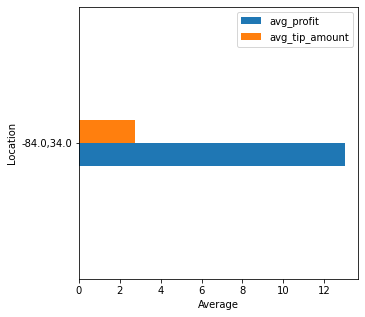

In [0]:
location(df,loc)

#4  Investigate one month of trips data in 2015 and 2018


Consider one month of trips data fromyellowtaxis for each year1.Filter and cache/persist the result

## 4.1  Assessing seasonalities and looking at time series

Compute and plot the following time series indexed by day of the week and hour of day:

1. The number of pickups
2. The average fare
3. The average trip duration
4. Plot the average number of ongoing trips

##4.2  Rides to the airports

In order to find the longitude and lattitude of JFK and Newark airport as well as the longitudeand magnitudes of Manhattan, you can use a service like geojson.io. Plot the following time series,indexed the day of the week and hour of the day
1. Median duration of taxi trip leaving Midtown (Southern Manhattan) headed for JFK Airport
2. Median taxi duration of trip leaving from JFK Airport to Midtown (Southern Manhattan)

##4.3  Geographic information

For this, you will need to find tools to display maps and to build choropeth maps. We let you lookand find relevant tools to do this.

1. Build a heatmap where color is a function of
   1. number ofpickups
   2. number ofdropoffs
   3. number ofpickupswith dropoff at some airport (JFK, LaGuardia, Newark)

2. Build a choropeth map where color is a function of
  1. number of pickups in the area
  2. ratio of number of payments by card/number of cash payments for pickups in the area 
  3. ratio of total fare/trip duration for dropoff in the area

3. Build an interactive chorophet with a slider allowing the user to select anhour of dayandwhere the color is a function of
  1. average number of dropoffs in the area during that hour the day 
  2. average ratio of tip over total fare amount for pickups in the area at given hour of theday